# Cell Image Visualization with MOA Effects

This notebook visualizes how different Mechanisms of Action (MOAs) affect cellular structures in the BBBC021 dataset.

The 3-channel images represent:
- **Channel 0 (Red)**: F-actin (cytoskeleton)
- **Channel 1 (Green)**: β-tubulin (microtubules)
- **Channel 2 (Blue)**: DNA (nuclei)

You can experiment a bit here by choosing different MOAs, no of images etc. We also implemented a per channel vis.

In [30]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from pybbbc import BBBC021, constants
import random
from collections import defaultdict
import pandas as pd

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

print("Available MOAs in BBBC021:")
print(constants.MOA)
print(f"\nTotal MOAs: {len(constants.MOA)}")

# Remove DMSO and null as they're not treatment effects
treatment_moas = [moa for moa in constants.MOA if moa not in ['DMSO', 'null']]
print(f"\nTreatment MOAs: {len(treatment_moas)}")
print(treatment_moas)

Available MOAs in BBBC021:
['Actin disruptors', 'Aurora kinase inhibitors', 'Cholesterol-lowering', 'DMSO', 'DNA damage', 'DNA replication', 'Eg5 inhibitors', 'Epithelial', 'Kinase inhibitors', 'Microtubule destabilizers', 'Microtubule stabilizers', 'Protein degradation', 'Protein synthesis', 'null']

Total MOAs: 14

Treatment MOAs: 12
['Actin disruptors', 'Aurora kinase inhibitors', 'Cholesterol-lowering', 'DNA damage', 'DNA replication', 'Eg5 inhibitors', 'Epithelial', 'Kinase inhibitors', 'Microtubule destabilizers', 'Microtubule stabilizers', 'Protein degradation', 'Protein synthesis']


In [31]:
# Configuration: Select MOAs to visualize
# You can modify this list to include any MOAs you want to compare
# they have to match the ones in constants.MOA
SELECTED_MOAS = [
    'Aurora kinase inhibitors',
    'Eg5 inhibitors',
    'Actin disruptors',
    'DMSO'  # Include DMSO as control
]

# Visualization parameters
IMAGES_PER_MOA = 3  # Number of example images per MOA
FIGURE_SIZE = (15, 10)  # Size of the visualization
DATA_ROOT = "/scratch/cv-course2025/group8"

print(f"Selected MOAs for visualization: {SELECTED_MOAS}")
print(f"Images per MOA: {IMAGES_PER_MOA}")

# Channel information
CHANNEL_NAMES = ['F-actin', 'β-tubulin', 'DAPI']
CHANNEL_COLORS = ['red', 'green', 'blue']
print(f"\nChannel mapping:")
for i, (name, color) in enumerate(zip(CHANNEL_NAMES, CHANNEL_COLORS)):
    print(f"  Channel {i}: {name} → {color}")

Selected MOAs for visualization: ['Aurora kinase inhibitors', 'Eg5 inhibitors', 'Actin disruptors', 'DMSO']
Images per MOA: 3

Channel mapping:
  Channel 0: F-actin → red
  Channel 1: β-tubulin → green
  Channel 2: DAPI → blue


In [32]:
def normalize_image_for_display(image):
    """
    Normalize image channels for display.
    Assumes image is in format (C, H, W) or (H, W, C)
    """
    if isinstance(image, torch.Tensor):
        image = image.numpy()
    
    # Handle different input formats
    if image.ndim == 3:
        if image.shape[0] == 3:  # (C, H, W) format
            image = np.transpose(image, (1, 2, 0))  # Convert to (H, W, C)
        elif image.shape[2] == 3:  # Already (H, W, C)
            pass
        else:
            raise ValueError(f"Unexpected image shape: {image.shape}")
    else:
        raise ValueError(f"Expected 3D image, got shape: {image.shape}")
    
    # Normalize each channel to [0, 1]
    normalized = np.zeros_like(image, dtype=np.float32)
    for c in range(image.shape[2]):
        channel = image[:, :, c]
        if channel.max() > channel.min():
            normalized[:, :, c] = (channel - channel.min()) / (channel.max() - channel.min())
        else:
            normalized[:, :, c] = channel
    
    return normalized

def collect_images_by_moa(moas_to_collect, max_images_per_moa=3):
    """
    Collect sample images for each MOA
    """
    moa_images = defaultdict(list)
    
    for moa in moas_to_collect:
        print(f"Collecting images for MOA: {moa}")
        
        # Create dataset for this MOA
        try:
            dataset = BBBC021(root_path=DATA_ROOT, moa=moa)
            images = dataset.images
            print(f"  Found {len(dataset)} images for {moa}")
            
            # Sample random images
            if len(dataset) > 0:
                sample_indices = random.sample(range(len(dataset)), 
                                             min(max_images_per_moa, len(dataset)))
                
                for idx in sample_indices:
                    image, metadata = dataset[idx]
                    moa_images[moa].append({
                        'image': image,
                        'metadata': metadata,
                        'compound': metadata.compound.compound,
                        'concentration': metadata.compound.concentration
                    })
                    
                print(f"  Collected {len(moa_images[moa])} images")
            else:
                print(f"  No images found for {moa}")
                
        except Exception as e:
            print(f"  Error loading {moa}: {e}")
    
    return moa_images

def plot_moa_comparison(moa_images, figsize=(15, 10)):
    """
    Create a comparison plot showing different MOAs and their effects
    """
    moas = list(moa_images.keys())
    max_images = max(len(images) for images in moa_images.values())
    
    fig, axes = plt.subplots(len(moas), max_images, figsize=figsize)
    
    # Handle case where we have only one MOA or one image
    if len(moas) == 1:
        axes = axes.reshape(1, -1)
    elif max_images == 1:
        axes = axes.reshape(-1, 1)
    
    for moa_idx, moa in enumerate(moas):
        images = moa_images[moa]
        
        for img_idx in range(max_images):
            if len(moas) == 1:
                ax = axes[img_idx]
            elif max_images == 1:
                ax = axes[moa_idx]
            else:
                ax = axes[moa_idx, img_idx]
            
            if img_idx < len(images):
                # Get and normalize image
                image_data = images[img_idx]['image']
                normalized_img = normalize_image_for_display(image_data)
                
                # Display RGB composite
                ax.imshow(normalized_img)
                
                # Add title with compound info
                compound = images[img_idx]['compound']
                concentration = images[img_idx]['concentration']
                
                if img_idx == 0:  # Only show MOA on first image
                    title = f"{moa}\n{compound} @ {concentration}"
                else:
                    title = f"{compound} @ {concentration}"
                
                ax.set_title(title, fontsize=8)
            else:
                # Empty subplot
                ax.set_visible(False)
            
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
    
    return fig

In [33]:
# Collect sample images for selected MOAs
print("Collecting images for selected MOAs...")
moa_images = collect_images_by_moa(SELECTED_MOAS, max_images_per_moa=IMAGES_PER_MOA)

# Display summary
print("\n" + "="*50)
print("COLLECTION SUMMARY")
print("="*50)
for moa, images in moa_images.items():
    print(f"{moa}: {len(images)} images")
    if images:
        compounds = set(img['compound'] for img in images)
        print(f"  Compounds: {', '.join(compounds)}")
print("="*50)

  Found 144 images for Aurora kinase inhibitors
  Collected 3 images
  Found 144 images for Eg5 inhibitors
  Collected 3 images
  Found 60 images for Actin disruptors
  Collected 3 images
  Found 1320 images for DMSO
  Collected 3 images

COLLECTION SUMMARY
Aurora kinase inhibitors: 3 images
  Compounds: AZ258, AZ-A
Eg5 inhibitors: 3 images
  Compounds: AZ-C, AZ138
Actin disruptors: 3 images
  Compounds: latrunculin B
DMSO: 3 images
  Compounds: DMSO


Creating MOA comparison visualization...


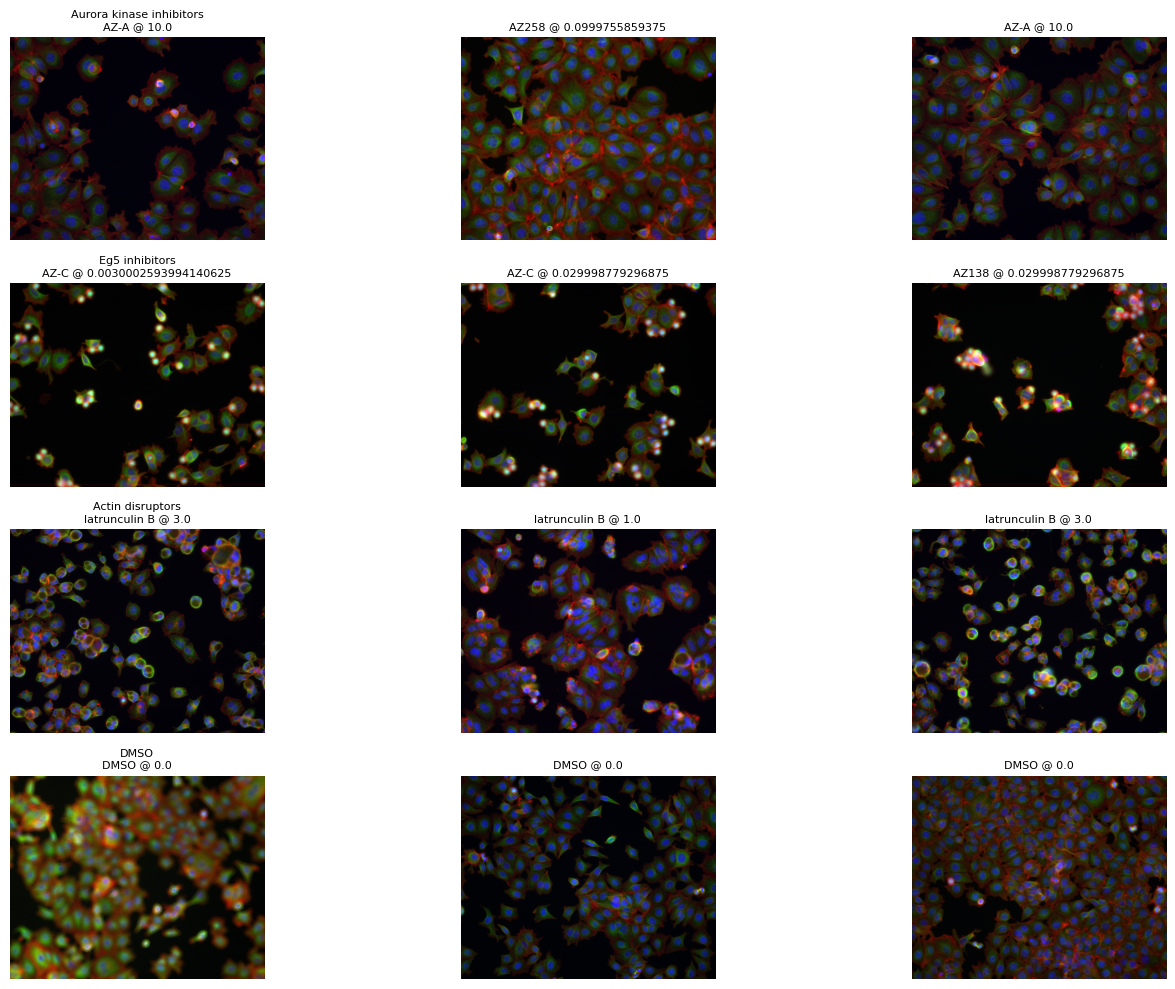

Text(0.5, 0.02, 'RGB Composite: Red = F-actin, Green = β-tubulin, Blue = DAPI')

In [34]:
# Create the main comparison visualization
print("Creating MOA comparison visualization...")
fig = plot_moa_comparison(moa_images, figsize=FIGURE_SIZE)

# Add figure legend
fig.text(0.5, 0.02, 
         f"RGB Composite: Red = {CHANNEL_NAMES[0]}, Green = {CHANNEL_NAMES[1]}, Blue = {CHANNEL_NAMES[2]}", 
         ha='center', fontsize=12, style='italic')

Showing individual channels for: Aurora kinase inhibitors


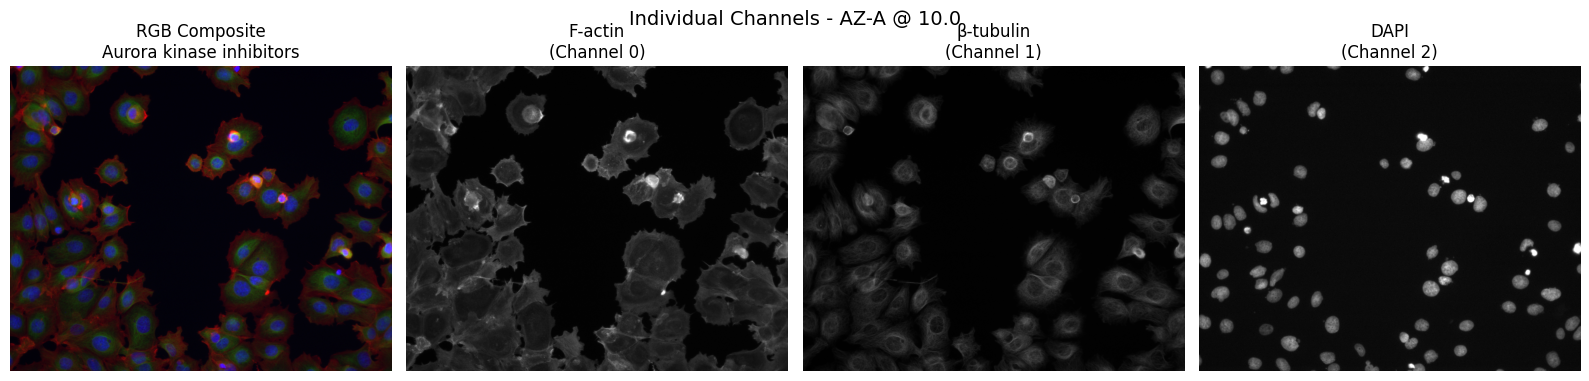

In [35]:
def plot_individual_channels(moa_images, selected_moa=None):
    """
    Plot individual channels for a specific MOA to see the effects more clearly
    """
    if selected_moa is None:
        selected_moa = list(moa_images.keys())[0]
    
    if selected_moa not in moa_images:
        print(f"MOA '{selected_moa}' not found in collected images")
        return
    
    images = moa_images[selected_moa]
    if not images:
        print(f"No images available for MOA '{selected_moa}'")
        return
    
    # Take the first image as example
    image_data = images[0]['image']
    compound = images[0]['compound']
    concentration = images[0]['concentration']
    
    if isinstance(image_data, torch.Tensor):
        image_data = image_data.numpy()
    
    # Ensure format is (H, W, C)
    if image_data.shape[0] == 3:
        image_data = np.transpose(image_data, (1, 2, 0))
    
    fig, axes = plt.subplots(1, 4, figsize=(16, 4))
    
    # Plot RGB composite
    normalized_img = normalize_image_for_display(image_data)
    axes[0].imshow(normalized_img)
    axes[0].set_title(f'RGB Composite\n{selected_moa}')
    axes[0].axis('off')
    
    # Plot individual channels
    for c in range(3):
        channel_img = image_data[:, :, c]
        # Normalize channel
        if channel_img.max() > channel_img.min():
            channel_normalized = (channel_img - channel_img.min()) / (channel_img.max() - channel_img.min())
        else:
            channel_normalized = channel_img
            
        axes[c+1].imshow(channel_normalized, cmap='gray')
        axes[c+1].set_title(f'{CHANNEL_NAMES[c]}\n(Channel {c})')
        axes[c+1].axis('off')
    
    plt.suptitle(f'Individual Channels - {compound} @ {concentration}', fontsize=14)
    plt.tight_layout()
    plt.show()
    
    return fig

# Example: Plot individual channels for the first MOA
if moa_images:
    first_moa = list(moa_images.keys())[0]
    print(f"Showing individual channels for: {first_moa}")
    plot_individual_channels(moa_images, first_moa)